# Mid Term Project

## Heart Disease Indicator
This notebook contains all data analysis and model building to help identify or indicate the likelihood of heart disease

In [386]:
# import necessary libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier

### Loading and Reading data

In [160]:
df = pd.read_csv('heart_2020_cleaned.csv')
display(df.head())
print()
display(df.info())

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     3

None

The **Heart Disease** column is what we are predicting.

### Data cleaning
converting all string to lowercase and encoding the "AgeCategory" feature

In [161]:
# convert all columns to lower
df.columns = df.columns.str.lower()
df.columns

Index(['heartdisease', 'bmi', 'smoking', 'alcoholdrinking', 'stroke',
       'physicalhealth', 'mentalhealth', 'diffwalking', 'sex', 'agecategory',
       'race', 'diabetic', 'physicalactivity', 'genhealth', 'sleeptime',
       'asthma', 'kidneydisease', 'skincancer'],
      dtype='object')

In [162]:
# change all "string" data to lowercase
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower()

In [163]:
# viewing the head
df.head().T

,0,1,2,3,4
heartdisease,no,no,no,no,no
bmi,16.6,20.34,26.58,24.21,23.71
smoking,yes,no,yes,no,no
alcoholdrinking,no,no,no,no,no
stroke,no,yes,no,no,no
physicalhealth,3.0,0.0,20.0,0.0,28.0
mentalhealth,30.0,0.0,30.0,0.0,0.0
diffwalking,no,no,no,no,yes
sex,female,female,male,female,female
agecategory,55-59,80 or older,65-69,75-79,40-44


In [164]:
list(df['agecategory'].unique())

['55-59',
 '80 or older',
 '65-69',
 '75-79',
 '40-44',
 '70-74',
 '60-64',
 '50-54',
 '45-49',
 '18-24',
 '35-39',
 '30-34',
 '25-29']

In [165]:
df['heartdisease'] = (df.heartdisease == 'yes').astype(int)

In [166]:
df.sample(6)

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
73485,1,28.17,no,no,no,13.0,0.0,yes,female,80 or older,white,yes,no,poor,4.0,no,no,no
104098,0,30.83,no,no,no,15.0,0.0,yes,male,75-79,white,no,yes,poor,7.0,yes,no,yes
286449,0,46.06,no,no,no,0.0,0.0,no,female,60-64,white,yes,no,good,8.0,no,no,no
142076,0,23.12,yes,no,no,30.0,30.0,no,male,45-49,white,yes,yes,fair,5.0,no,no,no
58749,0,35.24,no,no,no,5.0,15.0,no,male,55-59,white,yes,yes,good,6.0,yes,no,no
297828,0,32.01,no,no,yes,2.0,3.0,no,female,60-64,hispanic,no,yes,good,10.0,yes,no,no


### EDA

In [167]:
df.shape

(319795, 18)

In [168]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:7]) # looks for all unique values
    print(df[col].nunique())
    print()

heartdisease
[0 1]
2

bmi
[16.6  20.34 26.58 24.21 23.71 28.87 21.63]
3604

smoking
['yes' 'no']
2

alcoholdrinking
['no' 'yes']
2

stroke
['no' 'yes']
2

physicalhealth
[ 3.  0. 20. 28.  6. 15.  5.]
31

mentalhealth
[30.  0.  2.  5. 15.  8.  4.]
31

diffwalking
['no' 'yes']
2

sex
['female' 'male']
2

agecategory
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64']
13

race
['white' 'black' 'asian' 'american indian/alaskan native' 'other'
 'hispanic']
6

diabetic
['yes' 'no' 'no, borderline diabetes' 'yes (during pregnancy)']
4

physicalactivity
['yes' 'no']
2

genhealth
['very good' 'fair' 'good' 'poor' 'excellent']
5

sleeptime
[ 5.  7.  8.  6. 12.  4.  9.]
24

asthma
['yes' 'no']
2

kidneydisease
['no' 'yes']
2

skincancer
['yes' 'no']
2



In [169]:
df.isnull().sum()

heartdisease        0
bmi                 0
smoking             0
alcoholdrinking     0
stroke              0
physicalhealth      0
mentalhealth        0
diffwalking         0
sex                 0
agecategory         0
race                0
diabetic            0
physicalactivity    0
genhealth           0
sleeptime           0
asthma              0
kidneydisease       0
skincancer          0
dtype: int64

In [170]:
df.describe()

,heartdisease,bmi,physicalhealth,mentalhealth,sleeptime
count,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000
mean,0.085595,28.325399,3.37171,3.898366,7.097075
std,0.279766,6.356100,7.95085,7.955235,1.436007
min,0.000000,12.020000,0.00000,0.000000,1.000000
25%,0.000000,24.030000,0.00000,0.000000,6.000000
50%,0.000000,27.340000,0.00000,0.000000,7.000000
75%,0.000000,31.420000,2.00000,3.000000,8.000000
max,1.000000,94.850000,30.00000,30.000000,24.000000


Let's take a quick look at Target variable

Percentage of "being diagnosed with heart disease": % 8.56 --> (27373 heart diseases cases out of 319795)
Percentage of "NOT being diagnosed with heart disease": % 91.44 --> (292422 NOT churn cases out of 319795)


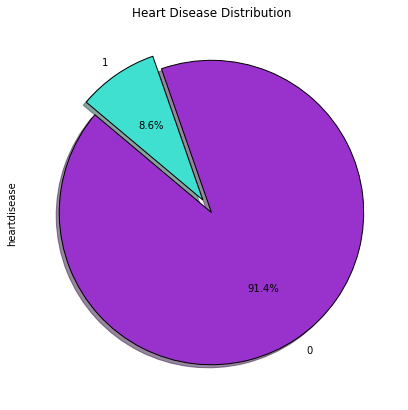

In [171]:
y = df['heartdisease']

print(f'Percentage of \033[1m"being diagnosed with heart disease"\033[0m: % {round(y.value_counts(normalize=True)[1]*100,2)} --> \
({y.value_counts()[1]} heart diseases cases out of {len(df)})\nPercentage of \033[1m"NOT being diagnosed with heart disease"\033[0m: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} NOT churn cases out of {len(df)})')

explode = [0, 0.1]

df["heartdisease"].value_counts().plot(kind="pie", 
                                 autopct='%1.1f%%', 
                                 figsize=(7, 7), 
                                 explode=explode, 
                                 wedgeprops={'edgecolor': 'black'}, 
                                 shadow=True, 
                                 colors = ['darkorchid', 'turquoise'], 
                                 startangle=140)
plt.title('Heart Disease Distribution');

We have a typical **class imbalance** here.
It is more likely not to have a heart disease from this dataset with a probability of 91.44%

In [172]:
df.corr() # correlation table 

,heartdisease,bmi,physicalhealth,mentalhealth,sleeptime
heartdisease,1.000000,0.051803,0.170721,0.028591,0.008327
bmi,0.051803,1.000000,0.109788,0.064131,-0.051822
physicalhealth,0.170721,0.109788,1.000000,0.287987,-0.061387
mentalhealth,0.028591,0.064131,0.287987,1.000000,-0.119717
sleeptime,0.008327,-0.051822,-0.061387,-0.119717,1.000000


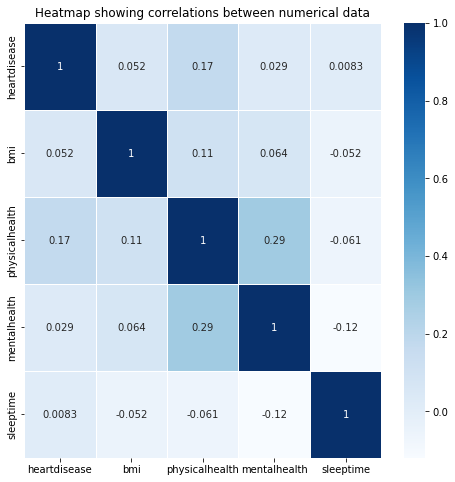

In [173]:
# this plot helps me to spot highest correlation
plt.figure(figsize=(8,8))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [174]:
df.corr().unstack().sort_values(ascending = False)

heartdisease    heartdisease      1.000000
bmi             bmi               1.000000
mentalhealth    mentalhealth      1.000000
physicalhealth  physicalhealth    1.000000
sleeptime       sleeptime         1.000000
physicalhealth  mentalhealth      0.287987
mentalhealth    physicalhealth    0.287987
heartdisease    physicalhealth    0.170721
physicalhealth  heartdisease      0.170721
bmi             physicalhealth    0.109788
physicalhealth  bmi               0.109788
bmi             mentalhealth      0.064131
mentalhealth    bmi               0.064131
heartdisease    bmi               0.051803
bmi             heartdisease      0.051803
heartdisease    mentalhealth      0.028591
mentalhealth    heartdisease      0.028591
sleeptime       heartdisease      0.008327
heartdisease    sleeptime         0.008327
bmi             sleeptime        -0.051822
sleeptime       bmi              -0.051822
                physicalhealth   -0.061387
physicalhealth  sleeptime        -0.061387
mentalhealt

There is some reasonable good correlation between **physical health** and **mental health**

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   heartdisease      319795 non-null  int32  
 1   bmi               319795 non-null  float64
 2   smoking           319795 non-null  object 
 3   alcoholdrinking   319795 non-null  object 
 4   stroke            319795 non-null  object 
 5   physicalhealth    319795 non-null  float64
 6   mentalhealth      319795 non-null  float64
 7   diffwalking       319795 non-null  object 
 8   sex               319795 non-null  object 
 9   agecategory       319795 non-null  object 
 10  race              319795 non-null  object 
 11  diabetic          319795 non-null  object 
 12  physicalactivity  319795 non-null  object 
 13  genhealth         319795 non-null  object 
 14  sleeptime         319795 non-null  float64
 15  asthma            319795 non-null  object 
 16  kidneydisease     31

In [176]:
numerical = ['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']
numerical

['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']

In [177]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['smoking',
 'alcoholdrinking',
 'stroke',
 'diffwalking',
 'sex',
 'agecategory',
 'race',
 'diabetic',
 'physicalactivity',
 'genhealth',
 'asthma',
 'kidneydisease',
 'skincancer']

### Data separation  - Setting up the validation framework

I am gonna split it into three datasets (train, val, and test) - training, validation and test datasets
I will use scikit-learn for this step

In [178]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [179]:
# sanity check
(len(df_train) / len(df)), (len(df_val) / len(df)), (len(df_val) / len(df))

(0.6, 0.2, 0.2)

In [180]:
df_train.head()

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
283797,0,23.34,yes,no,no,0.0,0.0,yes,female,75-79,black,no,yes,good,7.0,no,no,no
133469,1,31.87,yes,no,yes,0.0,0.0,yes,male,65-69,white,yes,no,fair,4.0,no,no,no
217392,0,27.37,yes,no,no,30.0,0.0,yes,male,65-69,white,yes,no,poor,6.0,yes,no,no
91650,0,27.44,no,no,no,0.0,0.0,no,female,60-64,white,no,yes,excellent,8.0,no,no,no
109459,0,27.41,no,no,no,0.0,0.0,no,female,50-54,white,no,yes,excellent,6.0,no,no,no


In [181]:
## reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [182]:
df_train.head()

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,23.34,yes,no,no,0.0,0.0,yes,female,75-79,black,no,yes,good,7.0,no,no,no
1,1,31.87,yes,no,yes,0.0,0.0,yes,male,65-69,white,yes,no,fair,4.0,no,no,no
2,0,27.37,yes,no,no,30.0,0.0,yes,male,65-69,white,yes,no,poor,6.0,yes,no,no
3,0,27.44,no,no,no,0.0,0.0,no,female,60-64,white,no,yes,excellent,8.0,no,no,no
4,0,27.41,no,no,no,0.0,0.0,no,female,50-54,white,no,yes,excellent,6.0,no,no,no


In [183]:
y_train = df_train.heartdisease.values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

In [184]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

In [185]:
# drop target column
df_train = df_train.drop('heartdisease', axis=1)
df_val = df_val.drop('heartdisease', axis=1)
df_test = df_test.drop('heartdisease', axis=1)

In [186]:
df_test.head()

,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,24.30,no,no,no,0.0,15.0,no,female,40-44,white,no,yes,excellent,7.0,no,no,no
1,23.78,yes,no,yes,0.0,0.0,yes,female,80 or older,black,yes,no,good,7.0,no,no,no
2,20.60,yes,no,no,0.0,0.0,no,female,70-74,white,no,yes,good,7.0,no,no,no
3,28.29,yes,no,no,0.0,20.0,no,female,25-29,white,no,no,good,4.0,no,no,no
4,33.00,no,no,no,0.0,0.0,no,male,75-79,white,yes,yes,excellent,8.0,no,no,no


I still want to know what variables are important. ROC AUC could also be used to evaluate feature importance of numerical variables.

In [187]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%15s, %.3f' % (c, auc))

            bmi, 0.559
 physicalhealth, 0.617
   mentalhealth, 0.503
      sleeptime, 0.506


We see that **physical health** is a serious feature 

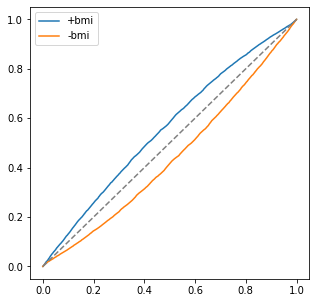

In [188]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.bmi)
plt.plot(fpr, tpr, label='+bmi')

fpr, tpr, _ = roc_curve(y_train, -df_train.bmi)
plt.plot(fpr, tpr, label='-bmi')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

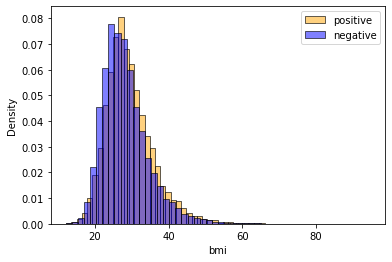

In [189]:
sns.histplot(df_train.bmi[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.bmi[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

In [190]:
df_full_train.head()

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
291133,0,24.53,yes,no,no,2.0,0.0,no,female,75-79,white,no,yes,fair,6.0,no,no,no
309330,0,33.00,yes,no,no,0.0,0.0,no,male,50-54,white,no,yes,excellent,7.0,no,no,no
307280,0,27.60,no,no,no,0.0,5.0,no,male,35-39,white,no,yes,excellent,9.0,no,no,no
7469,0,28.70,yes,no,no,0.0,14.0,no,male,45-49,white,no,yes,excellent,8.0,no,no,no
33630,1,28.98,yes,no,no,0.0,0.0,no,male,70-74,white,"no, borderline diabetes",yes,good,7.0,no,no,no


In [191]:
df_full_train[numerical].corrwith(df_full_train.heartdisease).abs().sort_values(ascending = False)

physicalhealth    0.169790
bmi               0.052349
mentalhealth      0.028456
sleeptime         0.007855
dtype: float64

From the above we can see that **physical health** places an important role in determining chances of a heart disease while **sleep time** has almost **no significance with 0.7%**

In [192]:
# determine the feature importance for the categorical variables
# use the mutual_info_score to determine the relation of 
# one categorical variable to the target variable

def mutual_info_heart_disease_score(series):
    return mutual_info_score(series, df_full_train.heartdisease)

In [193]:
categorical

['smoking',
 'alcoholdrinking',
 'stroke',
 'diffwalking',
 'sex',
 'agecategory',
 'race',
 'diabetic',
 'physicalactivity',
 'genhealth',
 'asthma',
 'kidneydisease',
 'skincancer']

In [194]:
mutual_info = df_full_train[categorical].apply(mutual_info_heart_disease_score)
mutual_info.sort_values(ascending=False)

agecategory         0.032074
genhealth           0.027688
diffwalking         0.015598
diabetic            0.013268
stroke              0.012182
kidneydisease       0.006800
smoking             0.005635
physicalactivity    0.004469
skincancer          0.003628
sex                 0.002500
race                0.001544
asthma              0.000829
alcoholdrinking     0.000578
dtype: float64

From the above, we can see that age category, general health, diffculty walking, diabetic and stroke have some effects on one having a heart disease. While suprisingly to me, alcohol consumption has very little importance

### Train / Build a model

In [195]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [196]:
model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [197]:
dict(zip(dv.get_feature_names_out(), model.coef_[0]))

{'agecategory=18-24': -1.6275737207217178,
 'agecategory=25-29': -1.402327663665428,
 'agecategory=30-34': -1.1171365891438791,
 'agecategory=35-39': -1.1097812098296356,
 'agecategory=40-44': -0.5859950467986866,
 'agecategory=45-49': -0.33030634476785126,
 'agecategory=50-54': 0.05751349026678776,
 'agecategory=55-59': 0.32342041400647215,
 'agecategory=60-64': 0.5940755224212528,
 'agecategory=65-69': 0.8302504172412559,
 'agecategory=70-74': 1.136802426763357,
 'agecategory=75-79': 1.3158061427861028,
 'agecategory=80 or older': 1.5756180246671572,
 'alcoholdrinking=no': -0.0641641509958219,
 'alcoholdrinking=yes': -0.27546998577993365,
 'asthma=no': -0.31915830446137583,
 'asthma=yes': -0.020475832314168753,
 'bmi': 0.008524129319718623,
 'diabetic=no': -0.29004523268205396,
 'diabetic=no, borderline diabetes': -0.14092089897659976,
 'diabetic=yes': 0.18749068841247893,
 'diabetic=yes (during pregnancy)': -0.09615869352832675,
 'diffwalking=no': -0.27376945401467584,
 'diffwalking

In [198]:
y_pred = model.predict_proba(X_val)[:, 1]

In [199]:
accuracy_score(y_val, y_pred >= 0.5).round(3)

0.915

We have an **accuracy score of 91.4%**

In [200]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

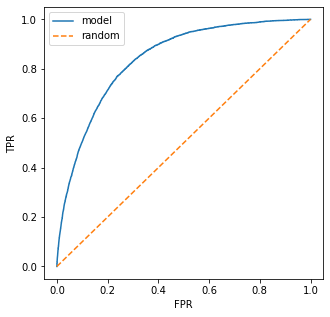

In [201]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [202]:
roc_auc_score(y_val, y_pred)

0.8405355265915435

And also just for our basic model we have an **AUC score of 84%**

### Building a Decision Tree Classifier

After using our logistic regression model, we get a score of 84%. Next, I'm trying to see if I can achieve an even higher performance

In [203]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [204]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [205]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.5845703105843942

A lower auc score compared to the **LogisticRegression** Model

In [206]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9999477307964958

We can see that the model is overfitting here hence the bad performance on the validation dataset.
I will try reducing the **depth** of the tree

In [207]:
# restrict depth search
dt = DecisionTreeClassifier(max_depth=9)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9)

In [208]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.8231927382843013
val: 0.8089674727760303


In [209]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- stroke=yes <= 0.50
|   |--- diffwalking=no <= 0.50
|   |   |--- diabetic=yes <= 0.50
|   |   |   |--- agecategory=80 or older <= 0.50
|   |   |   |   |--- genhealth=poor <= 0.50
|   |   |   |   |   |--- genhealth=fair <= 0.50
|   |   |   |   |   |   |--- agecategory=75-79 <= 0.50
|   |   |   |   |   |   |   |--- agecategory=70-74 <= 0.50
|   |   |   |   |   |   |   |   |--- smoking=yes <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- smoking=yes >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- agecategory=70-74 >  0.50
|   |   |   |   |   |   |   |   |--- sex=female <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- sex=female >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- agecategory=75-79 >  0.50
|   |   |   |   |   |   |   |--- sex=male <= 0.50
|   |   |   |   |   |   |   |   |--- kidneydisease=yes <= 0.50
| 

C:\Users\USER\anaconda3\envs\keras_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [210]:
depths = [1, 2, 3, 4, 5, 6, 9, 12, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.566
   2 -> 0.659
   3 -> 0.703
   4 -> 0.732
   5 -> 0.753
   6 -> 0.774
   9 -> 0.808
  12 -> 0.784
  15 -> 0.709
  20 -> 0.566
None -> 0.587


It is still worse than the **Logistic Regression** Model by 4%

In [211]:
scores = []

for depth in [6, 9, 12]:
    for min_sample in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_sample)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, min_sample, auc))

In [212]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [213]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth            6      9      12
min_samples_leaf                     
1                 0.774  0.808  0.784
5                 0.774  0.811  0.792
10                0.775  0.813  0.802
15                0.774  0.815  0.813
20                0.774  0.814  0.816
100               0.774  0.816  0.826
200               0.775  0.816  0.828
500               0.774  0.815  0.826

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

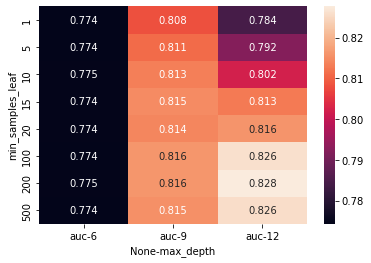

In [214]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", color='red')

We can see that best params for this tree is **min_sample_leaf=200** and **max_depth=12** but I will use **min_sample_leaf=100** and **max_depth=12** since there is a very little difference

In [219]:
dt = DecisionTreeClassifier(max_depth=12, min_samples_leaf=200)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=200)

In [220]:
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

val: 0.8276884958149023


We still have a **2%** drop compared to **Logistic Regression**

In [221]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

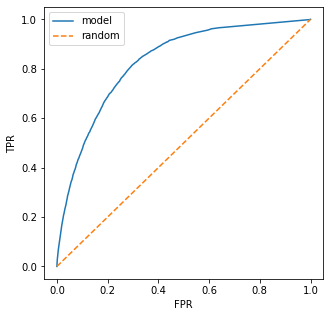

In [222]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### Random Forest & Ensembles

In [223]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [224]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

In [225]:
df_scores

,n_estimators,auc
0,10,0.735963
1,20,0.758673
2,30,0.768745
3,40,0.773777
4,50,0.777173
5,60,0.780219
6,70,0.781478
7,80,0.782666
8,90,0.784137
9,100,0.785017


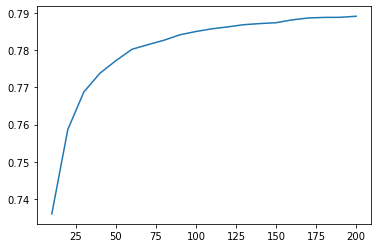

In [226]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [227]:
scores = []

# max-depths
for d in [10, 15, 20]:
    # no of estimators - no of trees
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [228]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

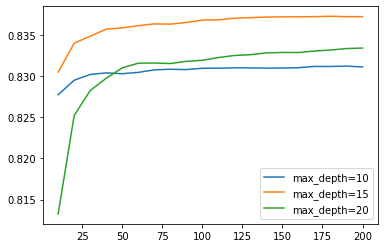

In [229]:
for d in [10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

Best max_depth = 10

In [232]:
max_depth=10

In [233]:
scores = []

for s in [1, 3, 5]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [234]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

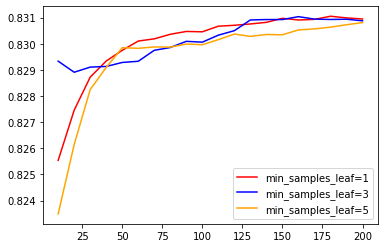

In [235]:
colors = ['red', 'blue', 'orange']

values = [1, 3, 5]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [236]:
min_samples_leaf = 1

In [237]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=1)

In [238]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

val: 0.8309470653257045


Still a little bit worse than our **Logistic Regression** model by **1%**

### Gradient Boosting with XGBoost

In [240]:
# we have to convert our data to a form that can be processed by xgBoost
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [241]:
features

array(['agecategory=18-24', 'agecategory=25-29', 'agecategory=30-34',
       'agecategory=35-39', 'agecategory=40-44', 'agecategory=45-49',
       'agecategory=50-54', 'agecategory=55-59', 'agecategory=60-64',
       'agecategory=65-69', 'agecategory=70-74', 'agecategory=75-79',
       'agecategory=80 or older', 'alcoholdrinking=no',
       'alcoholdrinking=yes', 'asthma=no', 'asthma=yes', 'bmi',
       'diabetic=no', 'diabetic=no, borderline diabetes', 'diabetic=yes',
       'diabetic=yes (during pregnancy)', 'diffwalking=no',
       'diffwalking=yes', 'genhealth=excellent', 'genhealth=fair',
       'genhealth=good', 'genhealth=poor', 'genhealth=very good',
       'kidneydisease=no', 'kidneydisease=yes', 'mentalhealth',
       'physicalactivity=no', 'physicalactivity=yes', 'physicalhealth',
       'race=american indian/alaskan native', 'race=asian', 'race=black',
       'race=hispanic', 'race=other', 'race=white', 'sex=female',
       'sex=male', 'skincancer=no', 'skincancer=yes', 'sl

In [242]:
# basic parameters for an xgBoost model
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [243]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8313894424154566

In [244]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [245]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [246]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [247]:
df_score = parse_xgb_output(output)

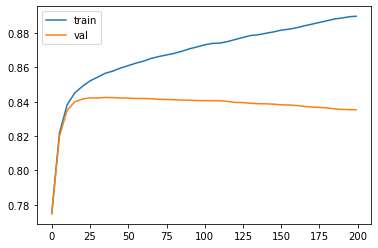

In [248]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

It is over-fitting as we can see. As it grows it learns the training set well but it is quite bad at predicting a new dataset

### we tune hyper-parameters

In [249]:
scores = {}

Tuning **learning rate**

In [261]:
%%capture output

xgb_params = {
    'eta': 1.0, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [262]:
key = 'eta={}'.format(xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

In [263]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=1.0'])

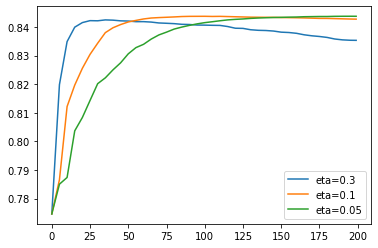

In [265]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.05']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

In [271]:
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,0.77534,0.77463
1,5,0.78695,0.78657
2,10,0.81297,0.81219
3,15,0.82072,0.81969
4,20,0.82688,0.82558
5,25,0.83267,0.83044
6,30,0.83746,0.83435
7,35,0.84144,0.83804
8,40,0.84368,0.83975
9,45,0.84539,0.84087


The best learning rate is **0.1** it best iteration is **60**

Next, we tune the **max_depth**

In [272]:
scores = {}

In [282]:
%%capture output

# eta is now 0.1
# max_depth_used while training = [3, 4, 6, 9, None]
xgb_params = {
    'eta': 0.1, 
    'max_depth': 9,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [283]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=9'

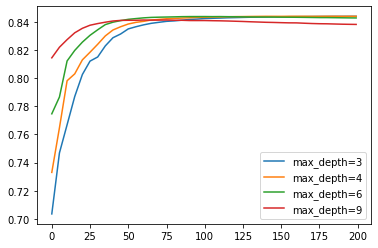

In [287]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

# plt.ylim(0.74, 0.86)
plt.legend()

I go with a **max_depth=6** because it starts performing well quickly and it stabilizes at the end too. **max_depth=3** starts achieving good performance really slow but also catches up.

Tuning **min_child_weight** hyperparameter

In [288]:
scores = {}

In [295]:
%%capture output


# min_child_weight = [1,10,15]
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 15,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [296]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=15'

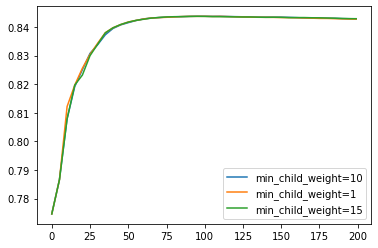

In [297]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

# plt.ylim(0.860, 0.8750)
plt.legend()

There is no difference in the range of **[1, 10, 15] min_child_weight** that I tried, so I stick with the minimum. **min_child_weight=1**

In [298]:
# the best model after tuning is
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

### Selecting the best model from the 4 models trained.

Basic Logistic Regression Model

In [306]:
# lr_model = Logistic Regression Model
lr_model = LogisticRegression(solver='liblinear', penalty='l2')
lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [307]:
lr_y_pred = lr_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, lr_y_pred)

0.8405355265915435

In [308]:
fpr, tpr, thresholds = roc_curve(y_val, lr_y_pred)

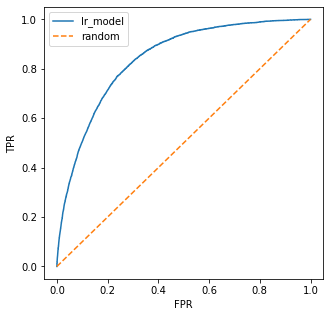

In [309]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='lr_model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

Decision Tree Classifier

In [310]:
dt = DecisionTreeClassifier(max_depth=12, min_samples_leaf=200)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=200)

In [311]:
dt_y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, dt_y_pred)

0.8276884958149023

In [312]:
fpr, tpr, thresholds = roc_curve(y_val, dt_y_pred)

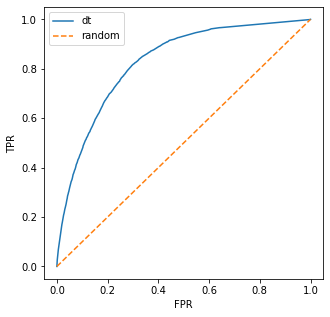

In [313]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='dt')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

Random Forest & Ensembles

In [314]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=1,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=1)

In [315]:
rf_y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, rf_y_pred)

0.8309470653257045

In [316]:
fpr, tpr, thresholds = roc_curve(y_val, rf_y_pred)

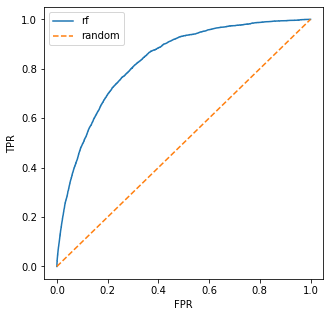

In [317]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='rf')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

XGBoost & Gradient Boosting

In [318]:
# the best model after tuning is
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [319]:
xgb_y_pred = xgb_model.predict(dval)
roc_auc_score(y_val, xgb_y_pred)

0.842773906434698

In [320]:
fpr, tpr, thresholds = roc_curve(y_val, xgb_y_pred)

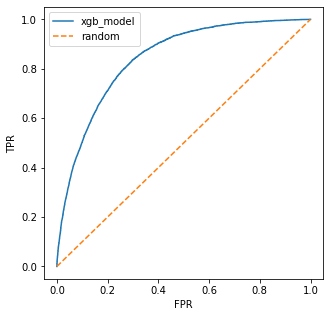

In [321]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='xgb_model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

The Xgb model is 0.3% better so we go with it

In [323]:
df_full_train = df_full_train.reset_index(drop=True)

In [324]:
df_full_train

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,24.53,yes,no,no,2.0,0.0,no,female,75-79,white,no,yes,fair,6.0,no,no,no
1,0,33.00,yes,no,no,0.0,0.0,no,male,50-54,white,no,yes,excellent,7.0,no,no,no
2,0,27.60,no,no,no,0.0,5.0,no,male,35-39,white,no,yes,excellent,9.0,no,no,no
3,0,28.70,yes,no,no,0.0,14.0,no,male,45-49,white,no,yes,excellent,8.0,no,no,no
4,1,28.98,yes,no,no,0.0,0.0,no,male,70-74,white,"no, borderline diabetes",yes,good,7.0,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255831,0,23.96,yes,no,no,0.0,0.0,yes,male,80 or older,white,no,yes,very good,10.0,no,no,yes
255832,0,28.62,yes,no,no,0.0,0.0,no,male,55-59,white,no,no,excellent,7.0,no,no,no
255833,0,19.53,yes,no,no,30.0,0.0,no,male,60-64,white,no,no,very good,7.0,no,no,no
255834,0,25.39,no,no,no,0.0,5.0,no,female,45-49,white,no,yes,good,7.0,yes,no,no


In [326]:
y_full_train = df_full_train.heartdisease
y_full_train

0         0
1         0
2         0
3         0
4         1
         ..
255831    0
255832    0
255833    0
255834    0
255835    0
Name: heartdisease, Length: 255836, dtype: int32

In [328]:
del df_full_train['heartdisease']

In [329]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [330]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [331]:
# the best model after tuning is
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [332]:
xgb_y_pred = xgb_model.predict(dval)
roc_auc_score(y_val, xgb_y_pred)

0.842773906434698

In [333]:
y_pred = xgb_model.predict(dtest)

In [334]:
roc_auc_score(y_test, y_pred)

0.8450991276769502

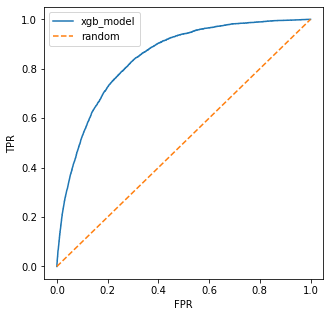

In [336]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)



plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='xgb_model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

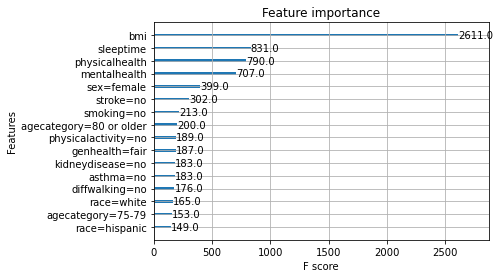

In [341]:
xgb.plot_importance(xgb_model,max_num_features=16 )

We can see the features which really affect the model. And here we see that your BMI is great factor in predicting someone's Heart Disease

### Using the XGB model


In [374]:
user_no = -3
patient = dicts_test[user_no]
patient

{'bmi': 34.09,
 'smoking': 'yes',
 'alcoholdrinking': 'no',
 'stroke': 'no',
 'physicalhealth': 28.0,
 'mentalhealth': 0.0,
 'diffwalking': 'no',
 'sex': 'male',
 'agecategory': '60-64',
 'race': 'white',
 'diabetic': 'no',
 'physicalactivity': 'yes',
 'genhealth': 'good',
 'sleeptime': 7.0,
 'asthma': 'no',
 'kidneydisease': 'no',
 'skincancer': 'no'}

In [375]:
y_test

array([0, 1, 0, ..., 1, 0, 0])

In [376]:
y_test[user_no]

1

In [377]:
X_one_patient = dv.transform([patient])
dtest = xgb.DMatrix(X_one_patient, feature_names=dv.get_feature_names_out())

In [378]:
heart_disease_prob = model.predict(dtest)[0]
heart_disease_prob

0.15354683

In [379]:
heart_disease_prob.astype(int)

0

In [380]:
if heart_disease_prob.astype(int) == 0:
    print('Customer MIGHT NOT have heart disease!')
else:
    print('Customer MIGHT have heart disease!')

Customer MIGHT NOT have heart disease!


### Save the model


In [383]:
# hyper-parameters for xgb model
eta = 0.1
max_depth = 6
min_child_weight = 1

In [384]:
output_file = 'xgb_model_eta={}_max_depth={}_min_child_weight={}.bin'.format(eta, max_depth, min_child_weight)
output_file

'xgb_model_eta=0.1_max_depth=6_min_child_weight=1.bin'

In [387]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, xgb_model), f_out)

### Using the model

In [388]:
model_filename = 'xgb_model_eta=0.1_max_depth=6_min_child_weight=1.bin'

In [389]:
with open(model_filename, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [390]:
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x226f9141088>)

In [392]:
selected_patient = 150
patient = dicts_test[selected_patient]
patient

{'bmi': 29.84,
 'smoking': 'no',
 'alcoholdrinking': 'no',
 'stroke': 'no',
 'physicalhealth': 5.0,
 'mentalhealth': 0.0,
 'diffwalking': 'no',
 'sex': 'male',
 'agecategory': '60-64',
 'race': 'white',
 'diabetic': 'no',
 'physicalactivity': 'yes',
 'genhealth': 'very good',
 'sleeptime': 8.0,
 'asthma': 'no',
 'kidneydisease': 'no',
 'skincancer': 'no'}

In [395]:
X= dv.transform([patient])
dtest = xgb.DMatrix(X, feature_names=dv.get_feature_names_out())

In [396]:
model.predict(dtest)[0]

0.0581077

In [399]:
y_test[selected_patient]

0